## Part-of-Speech tagging tutorial with the Keras Deep Learning library
In this tutorial, you will see how you can use a simple Keras model to train and evaluate an artificial neural network for multi-class classification problems.

In [1]:
# Ensure reproducibility

import numpy as np

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [2]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [4]:
import random
from nltk.corpus import treebank

sentences = treebank.tagged_sents(tagset='universal')
print('a random sentence: \n-> {}'.format(random.choice(sentences)))

a random sentence: 
-> [('Mr.', 'NOUN'), ('Bernstein', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-37', 'X'), ('succeeded', 'VERB'), ('Bennett', 'NOUN'), ('Cerf', 'NOUN'), (',', '.'), ('has', 'VERB'), ('been', 'VERB'), ('only', 'ADV'), ('the', 'DET'), ('second', 'ADJ'), ('president', 'NOUN'), ('of', 'ADP'), ('Random', 'NOUN'), ('House', 'NOUN'), ('since', 'ADP'), ('it', 'PRON'), ('was', 'VERB'), ('founded', 'VERB'), ('*-45', 'X'), ('in', 'ADP'), ('1925', 'NUM'), ('.', '.')]


In [6]:
tags = set([tag for sentence in treebank.tagged_sents() for _, tag in sentence])
print('nb_tags: {}\ntags: {}'.format(len(tags), tags))

nb_tags: 46
tags: {'CC', 'UH', '-LRB-', '$', 'SYM', 'NNS', 'RB', '#', 'NNPS', 'IN', 'RBS', 'VBD', 'MD', 'WP', 'CD', 'VBP', ':', 'WDT', '.', 'DT', 'RBR', 'PRP$', 'JJR', ',', 'VBZ', 'JJS', 'EX', 'VBN', '-NONE-', "''", 'VBG', 'POS', 'NN', 'WRB', '-RRB-', 'FW', 'VB', 'LS', 'PDT', '``', 'NNP', 'JJ', 'TO', 'WP$', 'RP', 'PRP'}


We use approximately 60% of the tagged sentences for training, 20% as the validation set and 20% to evaluate our model.

In [7]:
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
 
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

In [8]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.

        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [9]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term. 

    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.

    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []

    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

For training, validation and testing sentences, we split the attributes into X (input variables) and y (output variables).

In [10]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

Fit our DictVectorizer with our set of features

In [11]:
from sklearn.feature_extraction import DictVectorizer
 
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

Convert dict features to vectors

In [12]:
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

Fit LabelEncoder with our list of classes

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

LabelEncoder()

Encode class values as integers

In [14]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

Convert integers to dummy variables (one hot encoded)

In [15]:
from keras.utils import np_utils
 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

Using TensorFlow backend.


Define a simple Keras sequential model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Set model parameters and create a new sklearn classifier instance

In [17]:
from keras.wrappers.scikit_learn import KerasClassifier

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)

Finally, fit our classifier

In [18]:
hist = clf.fit(X_train, y_train)

Train on 61107 samples, validate on 19530 samples
Epoch 1/5
61107/61107 [==============================] - 96s 2ms/step - loss: 0.3951 - acc: 0.8837 - val_loss: 0.1687 - val_acc: 0.9449
Epoch 2/5
61107/61107 [==============================] - 91s 1ms/step - loss: 0.0735 - acc: 0.9763 - val_loss: 0.1414 - val_acc: 0.9584
Epoch 3/5
61107/61107 [==============================] - 95s 2ms/step - loss: 0.0360 - acc: 0.9889 - val_loss: 0.1483 - val_acc: 0.9560
Epoch 4/5
61107/61107 [==============================] - 93s 2ms/step - loss: 0.0293 - acc: 0.9911 - val_loss: 0.1551 - val_acc: 0.9589
Epoch 5/5
61107/61107 [==============================] - 92s 2ms/step - loss: 0.0261 - acc: 0.9920 - val_loss: 0.1684 - val_acc: 0.9570


In [21]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """

    green = '#72C29B'
    orange = '#FFA577'

    with plt.xkcd():
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
        ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=5,
                 label='training')
        ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange,
                 linewidth=5, label='validation')
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('loss')
        ax1.tick_params('y')
        ax1.legend(loc='upper right', shadow=False)
        ax1.set_title('Model loss through #epochs', fontweight='bold')

        ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=5,
                 label='training')
        ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
                 linewidth=5, label='validation')
        ax2.set_xlabel('# epoch')
        ax2.set_ylabel('accuracy')
        ax2.tick_params('y')
        ax2.legend(loc='lower right', shadow=False)
        ax2.set_title('Model accuracy through #epochs', fontweight='bold')

    plt.tight_layout()
    plt.show()

Plot model performance

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


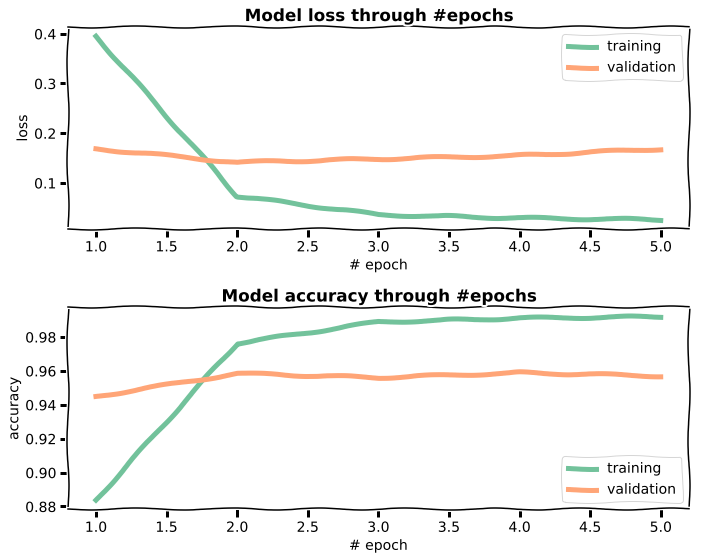

In [22]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

Evaluate model accuracy

In [25]:
score = clf.score(X_test, y_test, verbose=0)    
print('model accuracy: {}'.format(score))

model accuracy: 0.9657667548280853


Visualize model architecture

Finally, save model

In [ ]:
from keras.utils import plot_model

plot_model(clf.model, to_file='tmp/model_structure.png', show_shapes=True)

In [ ]:
clf.model.save('/tmp/keras_mlp.h5')